# Problem 3

## Preprocessing

In [10]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
from mne_icalabel import label_components

mne.set_log_level('WARNING')

dataset1_path = 'datasets/dataset1/S02_Sess05.set'
raw = mne.io.read_raw_eeglab(dataset1_path, preload=True, uint16_codec='latin1')
raw.set_eeg_reference(ref_channels='average')

events, event_id = mne.events_from_annotations(raw)
print('Event id mapping:', event_id)

fc_ch = 'FCz'


Event id mapping: {np.str_('FeedBack_correct'): 1, np.str_('FeedBack_wrong'): 2}


## 1. Apply all four following preprocessing flows before calculating ERP at FCz
1. Without any operation
2. Bandpass the signal (1~48 Hz)
3. Run ICA and remove bad components(Hint: using ICLabels)
4. Bandpass the signal (1~48 Hz) first and run ICA to remove bad components

In [11]:
def run_ica(raw_in):
    """Run ICA and remove components labeled as non brain using ICLabel.

    Components with labels in muscle, eog, ecg, line_noise, or ch_noise are excluded.
    """
    raw_proc = raw_in.copy()
    ica = ICA(method='infomax', fit_params=dict(extended=True), random_state=42)
    ica.fit(raw_proc)

    label_components(raw_proc, ica, method='iclabel')

    bad_ics = []
    exclude_keys = {'muscle', 'eog', 'ecg', 'line_noise', 'ch_noise'}
    for key, value in ica.labels_.items():
        if key in exclude_keys:
            bad_ics.extend(value)

    ica.exclude = bad_ics
    print('Excluded IC indices:', ica.exclude)
    if len(ica.exclude) > 0:
        ica.apply(raw_proc)

    return raw_proc, ica

raw_none = raw.copy()
raw_bp = raw.copy().filter(1.0, 48.0, fir_design='firwin')
raw_ica, ica_obj = run_ica(raw)
raw_bp2 = raw.copy().filter(1.0, 48.0, fir_design='firwin')
raw_bp_ica, ica_obj2 = run_ica(raw_bp2)

/var/folders/x1/2mv_vw1s4kl96_9cwpbwrxz80000gn/T/ipykernel_421/723530922.py:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw_proc)
/var/folders/x1/2mv_vw1s4kl96_9cwpbwrxz80000gn/T/ipykernel_421/723530922.py:10: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  label_components(raw_proc, ica, method='iclabel')


Excluded IC indices: [np.int64(54), np.int64(32), np.int64(8), np.int64(25)]


/var/folders/x1/2mv_vw1s4kl96_9cwpbwrxz80000gn/T/ipykernel_421/723530922.py:10: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  label_components(raw_proc, ica, method='iclabel')


Excluded IC indices: [np.int64(18), np.int64(20), np.int64(21), np.int64(27), np.int64(31), np.int64(32), np.int64(41), np.int64(43), np.int64(45), np.int64(48), np.int64(3), np.int64(17), np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(49)]


## 2. Helper functions for 
2. After the preprocessing, epoch the continuous EEG with a time interval [-0.2 1.3] sec, where t=0 is the feedback onset.
3. Remove the epoch baseline mean.

In [12]:
# Time window and baseline for epochs
tmin, tmax = -0.2, 1.3
baseline = (tmin, 0.0)  # remove mean from pre stimulus interval

def make_epochs(raw_proc):
    """Epoch around feedback events and apply baseline correction."""
    epochs = mne.Epochs(
        raw_proc,
        events,
        event_id=event_id,
        tmin=tmin,
        tmax=tmax,
        baseline=baseline,
        preload=True,
        picks='eeg',
    )
    return epochs


def compute_erp_and_snr(epochs, ch_name=fc_ch):
    """Return FCz ERPs for correct and error feedback, plus SNR for error ERP.
    SNR is defined as peak amplitude in [0, 1.0] s divided by
    the standard deviation of the pre stimulus interval [-0.2, 0] s.
    """
    evoked_correct = epochs['FeedBack_correct'].average()
    evoked_error = epochs['FeedBack_wrong'].average()

    evoked_correct_fc = evoked_correct.copy().pick(ch_name)
    evoked_error_fc = evoked_error.copy().pick(ch_name)

    times = evoked_error_fc.times
    data = evoked_error_fc.data[0]

    # Pre stimulus noise window: -200 to 0 ms
    pre_mask = (times >= -0.2) & (times <= 0.0)
    # Error related potential window: 0 to 1000 ms
    post_mask = (times >= 0.0) & (times <= 1.0)

    noise_std = np.std(data[pre_mask])
    peak_amp = np.max(np.abs(data[post_mask]))
    snr = peak_amp / noise_std

    return evoked_correct_fc, evoked_error_fc, snr

def plot_erp(evoked_correct_fc, evoked_error_fc, title, snr):
    """Plot FCz ERP for correct and error feedback and show SNR."""
    times_ms = evoked_correct_fc.times * 1000
    plt.figure(figsize=(6, 4))
    plt.plot(times_ms, evoked_correct_fc.data[0], label='correct')
    plt.plot(times_ms, evoked_error_fc.data[0], label='error')
    plt.axvline(0, linestyle='--', color='k')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (uV)')
    plt.title(f'{title}  SNR(error) = {snr:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4. Run the four flows

In [13]:
results = {}

### 4.1 Without any operation

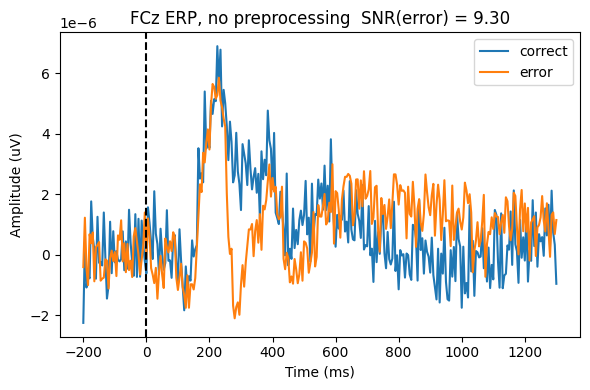

In [14]:
epochs_none = make_epochs(raw_none)
evc_none, eve_none, snr_none = compute_erp_and_snr(epochs_none)
results['Without any operation'] = snr_none
plot_erp(evc_none, eve_none, 'FCz ERP, no preprocessing', snr_none)

### 4.2 Bandpass only (1 to 48 Hz)

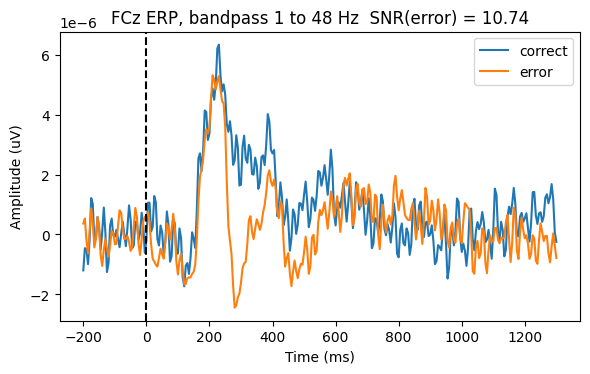

In [15]:
epochs_bp = make_epochs(raw_bp)
evc_bp, eve_bp, snr_bp = compute_erp_and_snr(epochs_bp)
results['Bandpass only'] = snr_bp
plot_erp(evc_bp, eve_bp, 'FCz ERP, bandpass 1 to 48 Hz', snr_bp)

### 4.3 ICA removal only

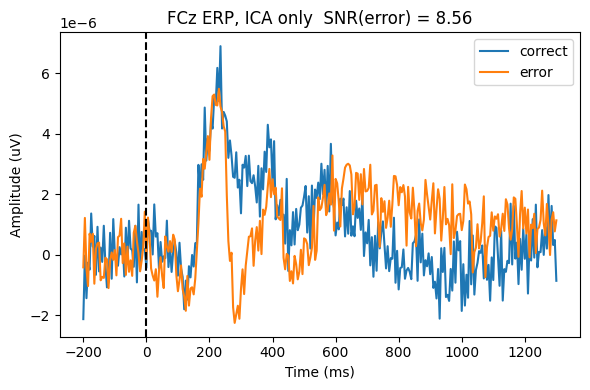

In [16]:
epochs_ica = make_epochs(raw_ica)
evc_ica, eve_ica, snr_ica = compute_erp_and_snr(epochs_ica)
results['IC removal only'] = snr_ica
plot_erp(evc_ica, eve_ica, 'FCz ERP, ICA only', snr_ica)

### 4.4 Bandpass plus ICA removal

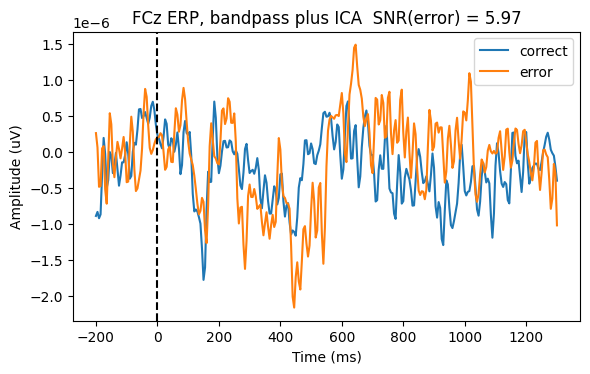

In [17]:
epochs_bp_ica = make_epochs(raw_bp_ica)
evc_bp_ica, eve_bp_ica, snr_bp_ica = compute_erp_and_snr(epochs_bp_ica)
results['Bandpass plus IC removal'] = snr_bp_ica
plot_erp(evc_bp_ica, eve_bp_ica, 'FCz ERP, bandpass plus ICA', snr_bp_ica)

## 5. SNR summary and table for the report

In [18]:
print('\nSNR summary for error feedback at FCz:')
for method, val in results.items():
    print(f'{method:25s}: {val:.3f}')

import pandas as pd
df = pd.DataFrame({
    'Preprocessing Methods': list(results.keys()),
    'SNR(error feedback only)': [results[k] for k in results],
})
print(df)


SNR summary for error feedback at FCz:
Without any operation    : 9.299
Bandpass only            : 10.735
IC removal only          : 8.561
Bandpass plus IC removal : 5.975
      Preprocessing Methods  SNR(error feedback only)
0     Without any operation                  9.299108
1             Bandpass only                 10.735238
2           IC removal only                  8.561486
3  Bandpass plus IC removal                  5.974602
